In [23]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
from pathlib import Path
import swifter # used even though marked as unused, do not delete 
from utils.fltrace_classes import *
from utils.constants import *
from utils.prepro import *
from plotters import plotter
import matplotlib.pyplot as plt
import functools as ft
import math
from itertools import chain
from sklearn.cluster import KMeans


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
PARENT_FOLDER_PATH = "../data/parsec_raw_out/"
OBJDUMP_FOLDER_PATH = "../data/objdumps/"

In [25]:
LOAD_DATA = "canneal"  

In [26]:
check_correct_dir(PARENT_FOLDER_PATH)

#dict of the form: {RunIdentifier : ExtraProcessCodeInfo}
extra_info = defaultdict(ExtraProcessCodeInfo)

#dicts of the form: {RunIdentifier : pandas.DataFrame}
all_dfs = {}
fltrace_impact_stats = {} # df contains (initial_trace_length, number_impacted_ips, idx_first_ip, idx_last_ip, max_num_consecutive)

def check_correct_grandchildren(bench_name: str,path_to_grandchild: Path):
    check_correct_dir_str(path_to_grandchild)
    grand_child_errorstr_prefix = f"Grandchild {path_to_grandchild.absolute().as_posix()}"
    dir_name = path_to_grandchild.name
    assert "_" in dir_name, (grand_child_errorstr_prefix + "does not contain '_' in its name")
    m,l = splitted_name = dir_name.split(sep='_')
    assert len(splitted_name) == 2, (grand_child_errorstr_prefix + "contains more than 1 '_' in its name")
    assert splitted_name[0].isnumeric() and splitted_name[1].isnumeric(), ("The M/L values of "+ grand_child_errorstr_prefix + "are not numbers")
    
    pids_to_procmaps_path = {}
    
    for trace_output in sorted(path_to_grandchild.iterdir(),reverse=True):
        trace_output: Path = trace_output
        assert trace_output.is_file()
        fname = trace_output.stem
        assert len(fname) > 0
        if fname[0] == ".":
            # Ignore hidden files
            continue
        assert fname.startswith(FLTRACE_OUTPUT_PREFIX), f"{trace_output.absolute().as_posix()} is not correctly prefixed"
        assert trace_output.suffix == FLTRACE_OUTPUT_SUFFIX, f"{trace_output.absolute().as_posix()} is not correctly suffixed"
        splitted_fname = fname.split("-")
        pid = int(splitted_fname[-2 if "faults" in fname else -1])
        filetype = splitted_fname[2]
        if filetype == "stats":
            continue
        elif filetype == "procmaps":
            pids_to_procmaps_path[pid] = trace_output
        elif filetype == "faults":
            assert pid in pids_to_procmaps_path.keys(), f"Received faults before procmaps here {trace_output.as_posix()}: are procmaps missing?"
            procmap_path = pids_to_procmaps_path[pid]
            runid = RunIdentifier(bench_name,int(m),int(l),pid)
            if (LOAD_DATA == "all" or 
                    ("/" in LOAD_DATA and (len(all_dfs) == 0 and LOAD_DATA == f"{bench_name}/{m}_{l}")) or
                    ("/" not in LOAD_DATA and LOAD_DATA==bench_name)
                ) :
                df = pd.read_csv(trace_output.as_posix())
                print(f"Loaded data for {runid}. Starting preprocessing.")
                df,epci = single_preprocess(runid,df, procmap_path,use_ints=True)
                print(f"Finished preprocessing data for {runid}.")
                all_dfs[runid] = df
                extra_info[runid] = epci
        else:
            raise LookupError(f"While looking at {bench_name}, found the following file in one of the grandchildren which doesn't seem to be the output of fltrace: {trace_output.absolute().as_posix()}")
def check_correct_children(path_to_child: Path):
    check_correct_dir_str(path_to_child)
    benchmark_name = path_to_child.name
    for grandchild in path_to_child.iterdir():
        check_correct_grandchildren(benchmark_name,grandchild)
    print(f"All checks pass for {benchmark_name}.")

In [ ]:
for child in Path(PARENT_FOLDER_PATH).iterdir():
    check_correct_children(child)

Loaded data for canneal_200_100_59559. Starting preprocessing.


Translating hex to int:   0%|          | 0/296847 [00:00<?, ?it/s]

Splitting and translating st:   0%|          | 0/296847 [00:00<?, ?it/s]

Inspect! canneal_200_100_59559: # of weird ips is 4
Splitting stacktraces (can take several minutes)


Finding all ip librairies..: 100%|██████████| 477/477 [00:00<00:00, 287454.46it/s]


Removing all ips before fltrace:   0%|          | 0/294137 [00:00<?, ?it/s]

In [ ]:
a = list(all_dfs.keys())
a

In [ ]:
rid1 = rid2 = None

In [ ]:
a1,e1 = all_dfs[rid1],extra_info[rid1]
a2,e2 = all_dfs[rid2],extra_info[rid1]

In [ ]:
a1["st_norm"] = a1["stacktrace"].swifter.apply(lambda st_lst: [ip-e1.libs[e1.libmap[ip]].base_addr for ip in st_lst])
a2["st_norm"] = a2["stacktrace"].swifter.apply(lambda st_lst: [ip-e2.libs[e2.libmap[ip]].base_addr for ip in st_lst])

In [ ]:
assert False

In [ ]:
R_LEN = 21
R_NAMES = ["r15","r14","r13","r12","rbp","rbx","r11","r10","r9","r8","rax","rcx","rdx","rsi","rdi","orig_rax","rip","cs","eflags","rsp","ss"]

In [ ]:
rid_analisis = a[-1]
analysis_df = all_dfs[rid_analisis]
start_point = analysis_df["tstamp"].min()
analysis_df["relative_tstamp"] = analysis_df["tstamp"].apply(lambda t: t-start_point)

In [ ]:
gb = analysis_df.copy().reset_index()
gb["regs"] = gb["regs"].swifter.apply(lambda reg_str: np.array([int(x) for x in reg_str.split('!') if x != '']))
gb = gb.groupby(by="stacktrace")

Pandas Apply:   0%|          | 0/366232 [00:00<?, ?it/s]

In [ ]:
from tqdm import tqdm
def get_regs_graphs(gb,color_dict):
    def create_axes(n_plots, max_cols=4):
        n_rows = math.ceil(n_plots / max_cols)
        fig = plt.figure(figsize=(15, 3*n_rows))
        axes = []
        
        for i in range(n_plots):
            row = i // max_cols
            col = i % max_cols
            ax = plt.subplot2grid((n_rows, max_cols), (row, col))
            ax.set_title(f"Register ${R_NAMES[i]}$")
            axes.append(ax)
        
        plt.tight_layout()
        return fig, axes

    fig,axs = create_axes(R_LEN,max_cols=4)

    def populate_graph(gname,regs_np,tsts):
        for reg_i in range(R_LEN):
            reg_ax = axs[reg_i]
            data = regs_np[:,reg_i]
            reg_ax.scatter(tsts,data,color=([color_dict[gname]]*len(data)),alpha=0.6,label=gname,marker='.')

    for group in tqdm(gb.stacktrace.unique(),total=len(gb.stacktrace.unique())):
        grouped_df = gb.get_group(group[0])
        regs_np = np.stack(grouped_df["regs"].values)
        tsts_np = np.stack(grouped_df["relative_tstamp"].values)
        populate_graph(group[0],regs_np,tsts_np)
    return fig,axs

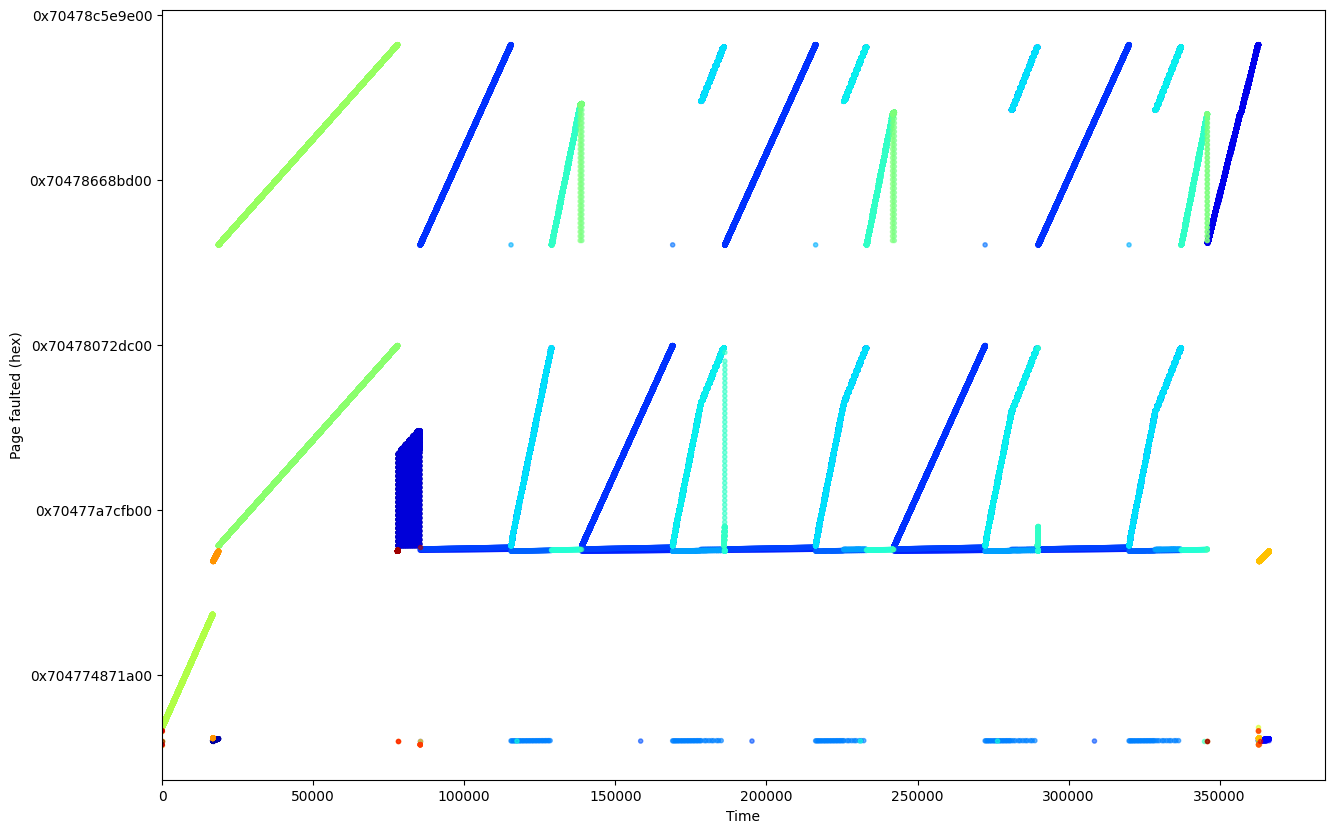

In [ ]:
_,_,color_dict = plotter.get_time_graph(pd.concat([analysis_df.groupby("stacktrace")["addr"].apply(list).rename("pages").apply(lambda addr_list: [int(addr,16) & ~(PAGE_SIZE-1)  for addr in addr_list]),analysis_df.groupby("stacktrace").size().rename("num_occurrences"),analysis_df.reset_index().groupby("stacktrace")["index"].apply(list).rename("index_occurrences")],axis=1).reset_index())

100%|██████████| 65/65 [02:41<00:00,  2.48s/it]


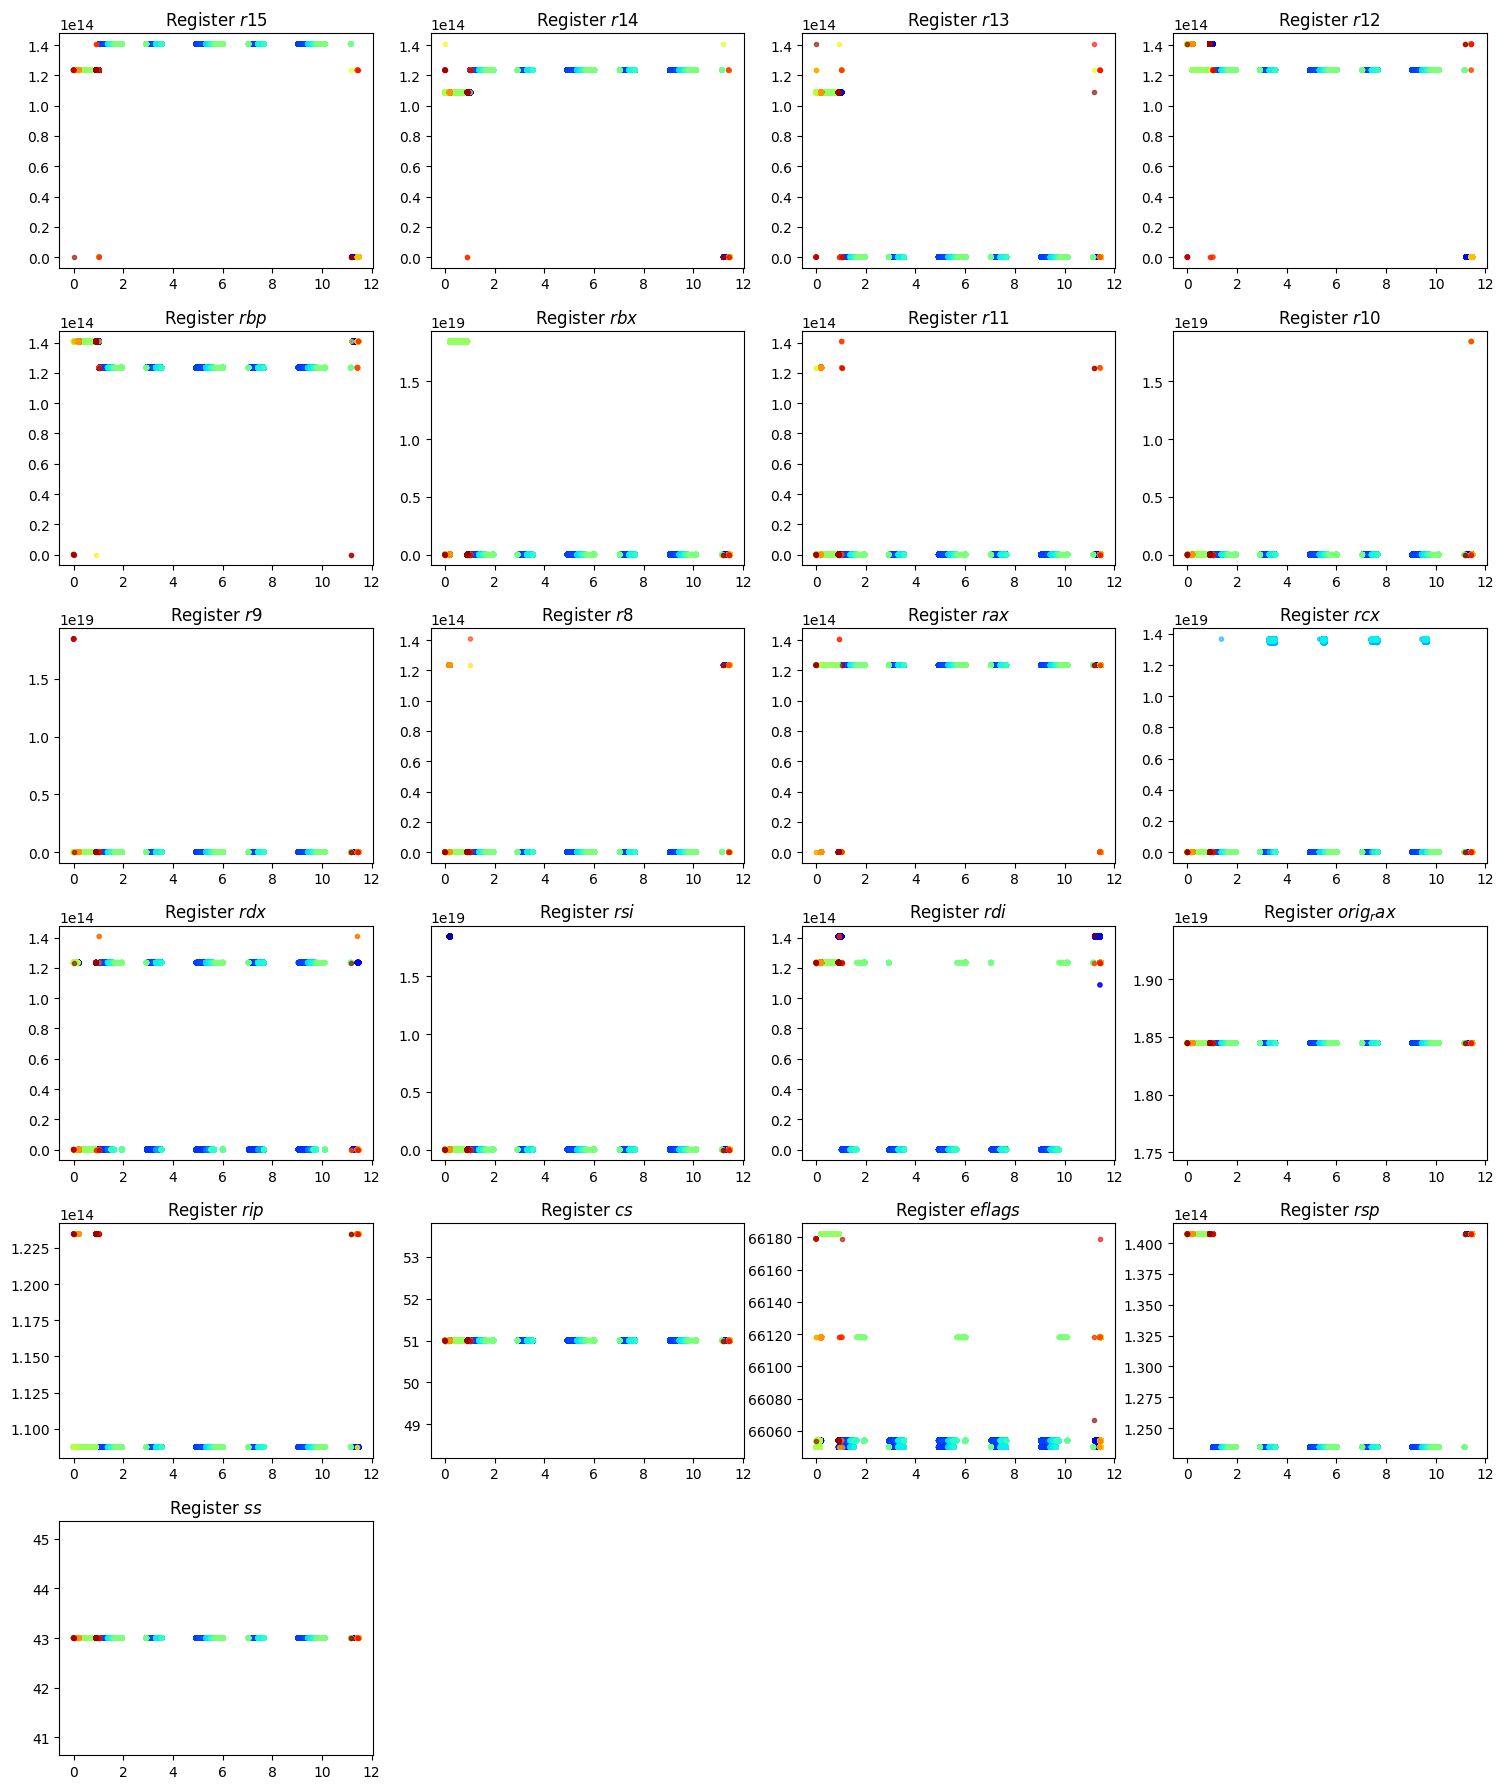

In [ ]:
f,ax = get_regs_graphs(gb,color_dict=color_dict)
f.savefig("outs/reg_normal.png")

In [ ]:
new_analysis = analysis_df.copy()
new_analysis["regs"] = new_analysis["regs"].swifter.apply(lambda reg_str: np.array([int(x) for x in reg_str.split('!') if x != '']))

Pandas Apply:   0%|          | 0/366232 [00:00<?, ?it/s]

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import math
from sklearn.cluster import KMeans
from matplotlib import gridspec
from tqdm import tqdm

def find_K(data, alpha=0.3):
    """Determine K by finding maximum number of values that are at least alpha apart"""
    sorted_unique = np.sort(np.unique(data.round(decimals=2)))
    gaps = np.diff(sorted_unique)
    gap_indices = np.where(gaps >= alpha)[0] + 1
    
    if len(gap_indices) == 0:
        return 1
    
    groups = np.split(sorted_unique, gap_indices)
    return len(groups)

def create_axes(n_regs, Ks, max_cols=4):
    n_rows = math.ceil(n_regs / max_cols)
    fig = plt.figure(figsize=(15, 5*n_rows))
    axes = []
    
    for i in range(n_regs):
        row = i // max_cols
        col = i % max_cols
        K = Ks[i]
        if K > 6:
            raise ValueError("too many clusters") 
        gs = gridspec.GridSpecFromSubplotSpec(K, 1, 
            subplot_spec=gridspec.GridSpec(n_rows, max_cols)[row, col],
            height_ratios=[1]*K, hspace=0.15)
        
        subplot_group = []
        for k in range(K):
            ax = fig.add_subplot(gs[k])
            subplot_group.append(ax)
        axes.append(subplot_group)
    
    plt.tight_layout()
    return fig, axes

def plot_register_data(data_array, custom_Ks=None, alpha=1e8, max_cols=4):
    """
    Plot register data from a 2D numpy array
    
    Parameters:
    data_array : np.ndarray of shape (N, N_REGS)
        Each column is a register's data
    custom_Ks : array-like or None
        Optional array of K values for each register. Must have length N_REGS if provided.
        If None, K values will be automatically detected using find_K.
    alpha : float
        Threshold for determining separate clusters (used only if custom_Ks is None)
    max_cols : int
        Maximum number of columns in the plot grid
    padding : float
        Padding around clusters in the plots
    """
    N, N_REGS = data_array.shape
    
    # Validate custom_Ks if provided
    if custom_Ks is not None:
        custom_Ks = np.array(custom_Ks)
        if len(custom_Ks) != N_REGS:
            raise ValueError(f"custom_Ks must have length {N_REGS}, got {len(custom_Ks)}")
        if not np.all(custom_Ks > 0):
            raise ValueError("All K values must be positive")
        if not np.all(np.issubdtype(custom_Ks.dtype, np.integer)):
            raise ValueError("All K values must be integers")
        Ks = custom_Ks
    else:
        # Find K for each register using automatic detection
        Ks = [find_K(data_array[:, i], alpha) for i in range(N_REGS)]
    
    print(f"Using K values: {Ks}")
    
    # Create axes
    fig, axes_groups = create_axes(N_REGS, Ks, max_cols)
    
    # Plot each register
    for reg_idx in tqdm(range(N_REGS), total=N_REGS):
        axes_group = axes_groups[reg_idx]
        data = data_array[:, reg_idx]
        K = Ks[reg_idx]
        
        if K == 1:
            ax = axes_group[0]
            ax.scatter(np.arange(N), data, alpha=0.6,marker=',',color=idx_to_color)
            ax.set_title(f'Register {R_NAMES[reg_idx]} (K=1)')
            continue
            
        x = np.arange(N)
        y = data
        
        # Perform clustering
        kmeans = KMeans(n_clusters=K, random_state=42)
        clusters = kmeans.fit_predict(y.reshape(-1, 1))
        centers = kmeans.cluster_centers_.flatten()

        cond = ((y<1e12) & (clusters != np.argmin(centers)))
        print(f"Points with y<1e12 not associated with the cluster of smallest center: {x[cond]}," 
        +f"associated to clusters # {clusters[cond]}," 
        +f"with center {centers[clusters[cond]]}")

        print(y[341265:341267],clusters[341265:341267],centers[clusters[341265:341267]])


        # Sort clusters by center values
        sorted_centers_idx = np.argsort(centers)[::-1]
        print(sorted_centers_idx)
        centers = centers[sorted_centers_idx]

        
        # Create mapping from original cluster labels to sorted labels
        cluster_map = {old: new for new, old in enumerate(sorted_centers_idx)}
        sorted_clusters = np.array([cluster_map[c] for c in clusters])
        

        # Plot each cluster
        total_sum = 0
        for ax_idx, ax in tqdm(enumerate(axes_group), total=len(axes_group), desc="Plotting each cluster"):
            cluster_mask = sorted_clusters == ax_idx
            cluster_points = y[cluster_mask]
            print("Clusters:",cluster_points.min(),cluster_points.max())
            print(TEXT_SEPARATOR)

            cluster_x = x[cluster_mask]
            total_sum += np.sum(cluster_mask)

            if len(cluster_points) > 0:

                y_offset = np.min(cluster_points)
                print(y_offset)
                normalized_points = cluster_points - y_offset
                
                padding = (np.max(normalized_points)) // 10
                print(padding)
                y_min = 0 - padding
                y_max = np.max(normalized_points) + padding

                ax.clear()
                ax.autoscale(enable=False)

                pc = ax.scatter(cluster_x, normalized_points, alpha=0.6,marker=',',color=idx_to_color[cluster_mask],zorder=2)
            
                ax.set_ylim(y_min, y_max)
                ax.set_xlim(np.min(x), np.max(x) + np.max(x)//100)

                def format_func(y, pos):
                    return f'{y + y_offset:.4E}'
                
                ax.yaxis.set_major_formatter(plt.FuncFormatter(format_func))
        
        
            # Debug after scatter
            print(f"After scatter - ylim: {ax.get_ylim()}")
            print(f"DataLim: {ax.dataLim.bounds}")
            print(f"ViewLim: {ax.viewLim.bounds}")
            
            # Add break markers with explicit transform
            if ax_idx != K-1:
                ax.spines['bottom'].set_visible(False)
                ax.set_xticks([])
                d = .015
                kwargs = dict(transform=ax.transAxes, color='r', clip_on=False, zorder=10)
                ax.plot((-d, +d), (-d, +d), **kwargs)
                ax.plot((1-d, 1+d), (-d, +d), **kwargs)
                
            if ax_idx != 0:
                ax.spines['top'].set_visible(False)
                d = .015
                kwargs = dict(transform=ax.transAxes, color='r', clip_on=False, zorder=10)
                ax.plot((-d, +d), (1-d, 1+d), **kwargs)
                ax.plot((1-d, 1+d), (1-d, 1+d), **kwargs)    

            points = pc.get_offsets()
            print(f"Normalized points y range: {np.min(points[:,1])} to {np.max(points[:,1])}")
            transformed = ax.transData.transform(points)
            print(f"Transformed points y range: {np.min(transformed[:,1])} to {np.max(transformed[:,1])}")
            # Final debug
            print(f"Final ylim: {ax.get_ylim()}\n")

        print(total_sum)
        print(TEXT_SEPARATOR)
        #assert False
        # Labels and title
        axes_group[-1].set_xlabel('Time')
        if K > 2:
            axes_group[K//2].set_ylabel('Value')
        else:
            axes_group[0].set_ylabel('Value')
        axes_group[0].set_title(f'Register {R_NAMES[reg_idx]} (K={K})')
    
    plt.tight_layout()
    return fig, axes_groups

In [ ]:
all_regs_data = None
idx_to_color = np.zeros((len(analysis_df),len(list(color_dict.values())[0])))
for group in gb.stacktrace.unique():
    group_name = group[0]
    grouped_df = gb.get_group(group[0])
    group_vals = np.stack(grouped_df["regs"].values)
    if all_regs_data is None:
        all_regs_data = group_vals
    else:
        all_regs_data = np.vstack((all_regs_data,group_vals))
    idx_to_color[grouped_df.index.values] = color_dict[group_name]
print(all_regs_data.shape)

(366232, 21)


Using K values: [3 3 4 3 3 2 3 2 2 3 3 3 3 2 4 1 2 1 3 2 1]


  0%|          | 0/21 [00:00<?, ?it/s]

Points with y<1e12 not associated with the cluster of smallest center: [],associated to clusters # [],with center []
[1.23453543e+14 1.23453543e+14] [2 2] [1.23453542e+14 1.23453542e+14]
[0 2 1]


Clusters: 140736299713992.0 140736299714528.0
______________________________
140736299713992.0
53.0
After scatter - ylim: (-53.0, 589.0)
DataLim: (24821.0, 0.0, 341266.0, 536.0)
ViewLim: (0.0, -53.0, 369893.0, 642.0)
Normalized points y range: 0.0 to 536.0
Transformed points y range: 2853.482530392188 to 2968.16056725091
Final ylim: (-53.0, 589.0)

Clusters: 123452157593984.0 123453542527040.0
______________________________
123452157593984.0
138493305.0


  5%|▍         | 1/21 [00:00<00:08,  2.28it/s]

After scatter - ylim: (-138493305.0, 1523426361.0)
DataLim: (0.0, 0.0, 366229.0, 1384933056.0)
ViewLim: (0.0, -138493305.0, 369893.0, 1661919666.0)
Normalized points y range: 0.0 to 1384933056.0
Transformed points y range: 2695.6290684210767 to 2810.0931538011455
Final ylim: (-138493305.0, 1523426361.0)

Clusters: 0.0 192.0
______________________________
0.0
19.0
After scatter - ylim: (-19.0, 211.0)
DataLim: (7664.0, 0.0, 358567.0, 192.0)
ViewLim: (0.0, -19.0, 369893.0, 230.0)
Normalized points y range: 0.0 to 192.0
Transformed points y range: 2537.569096764749 to 2652.232250036598
Final ylim: (-19.0, 211.0)

366232
______________________________
Points with y<1e12 not associated with the cluster of smallest center: [],associated to clusters # [],with center []
[1.08744961e+14 1.08744961e+14] [2 2] [1.08744961e+14 1.08744961e+14]
[0 2 1]


Clusters: 123452157591824.0 140736299722015.0
______________________________
123452157591824.0
1728414213019.0
After scatter - ylim: (-1728414213019.0, 19012556343210.0)
DataLim: (24821.0, 0.0, 341409.0, 17284142130191.0)
ViewLim: (0.0, -1728414213019.0, 369893.0, 20740970556229.0)
Normalized points y range: 0.0 to 17284142130191.0
Transformed points y range: 2853.5895061728393 to 2968.0535914702587
Final ylim: (-1728414213019.0, 19012556343210.0)

Clusters: 108744960535632.0 108744960535632.0
______________________________
108744960535632.0
0.0


/tmp/ipykernel_627749/2702798653.py:148: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(y_min, y_max)
 10%|▉         | 2/21 [00:00<00:08,  2.36it/s]

After scatter - ylim: (-0.05, 0.05)
DataLim: (0.0, 0.0, 366229.0, 0.0)
ViewLim: (0.0, -0.05, 369893.0, 0.1)
Normalized points y range: 0.0 to 0.0
Transformed points y range: 2752.8611111111113 to 2752.8611111111113
Final ylim: (-0.05, 0.05)

Clusters: 1.0 100.0
______________________________
1.0
9.0
After scatter - ylim: (-9.0, 108.0)
DataLim: (7664.0, 0.0, 358567.0, 99.0)
ViewLim: (0.0, -9.0, 369893.0, 117.0)
Normalized points y range: 0.0 to 99.0
Transformed points y range: 2536.7881377881376 to 2653.0132090132092
Final ylim: (-9.0, 108.0)

366232
______________________________
Points with y<1e12 not associated with the cluster of smallest center: [],associated to clusters # [],with center []
[1.08744961e+14 1.08744961e+14] [1 1] [1.08744961e+14 1.08744961e+14]
[3 2 1 0]


Clusters: 140736299714168.0 140736299715208.0
______________________________
140736299714168.0
104.0
After scatter - ylim: (-104.0, 1144.0)
DataLim: (361304.0, 0.0, 4926.0, 1040.0)
ViewLim: (0.0, -104.0, 369893.0, 1248.0)
Normalized points y range: 0.0 to 1040.0
Transformed points y range: 2886.128173116937 to 2971.0116521015398
Final ylim: (-104.0, 1144.0)

Clusters: 123452157591744.0 123453542039104.0
______________________________
123452157591744.0
138444736.0
After scatter - ylim: (-138444736.0, 1522892096.0)
DataLim: (361302.0, 0.0, 4787.0, 1384447360.0)
ViewLim: (0.0, -138444736.0, 369893.0, 1661336832.0)
Normalized points y range: 0.0 to 1384447360.0
Transformed points y range: 2768.9889721181858 to 2853.872451102788
Final ylim: (-138444736.0, 1522892096.0)

Clusters: 108744960514952.0 108744960537256.0
______________________________
108744960514952.0
2230.0
After scatter - ylim: (-2230.0, 24534.0)
DataLim: (0.0, 0.0, 366231.0, 22304.0)
ViewLim: (0.0, -2230.0, 369893.0, 26764.0)

 14%|█▍        | 3/21 [00:01<00:07,  2.30it/s]

After scatter - ylim: (-3.0, 42.0)
DataLim: (7664.0, 0.0, 358432.0, 39.0)
ViewLim: (0.0, -3.0, 369893.0, 45.0)
Normalized points y range: 0.0 to 39.0
Transformed points y range: 2533.0129005409904 to 2621.2917186849772
Final ylim: (-3.0, 42.0)

366232
______________________________
Points with y<1e12 not associated with the cluster of smallest center: [],associated to clusters # [],with center []
[1.23452568e+14 1.23452568e+14] [0 0] [1.23451379e+14 1.23451379e+14]
[2 0 1]


Clusters: 140736299703428.0 140736299722015.0
______________________________
140736299703428.0
1858.0
After scatter - ylim: (-1858.0, 20445.0)
DataLim: (0.0, 0.0, 366231.0, 18587.0)
ViewLim: (0.0, -1858.0, 369893.0, 22303.0)
Normalized points y range: 0.0 to 18587.0
Transformed points y range: 2853.5859136131076 to 2968.0571840299904
Final ylim: (-1858.0, 20445.0)

Clusters: 123451140474432.0 123453542025544.0
______________________________
123451140474432.0
240155111.0


 19%|█▉        | 4/21 [00:01<00:07,  2.30it/s]

After scatter - ylim: (-240155111.0, 2641706223.0)
DataLim: (24821.0, 0.0, 341275.0, 2401551112.0)
ViewLim: (0.0, -240155111.0, 369893.0, 2881861334.0)
Normalized points y range: 0.0 to 2401551112.0
Transformed points y range: 2695.629068454458 to 2810.0931537677648
Final ylim: (-240155111.0, 2641706223.0)

Clusters: 0.0 20480.0
______________________________
0.0
2048.0
After scatter - ylim: (-2048.0, 22528.0)
DataLim: (7664.0, 0.0, 358431.0, 20480.0)
ViewLim: (0.0, -2048.0, 369893.0, 24576.0)
Normalized points y range: 0.0 to 20480.0
Transformed points y range: 2537.668630751964 to 2652.132716049383
Final ylim: (-2048.0, 22528.0)

366232
______________________________
Points with y<1e12 not associated with the cluster of smallest center: [],associated to clusters # [],with center []
[1.407363e+14 1.407363e+14] [1 1] [1.407363e+14 1.407363e+14]
[1 0 2]


Clusters: 140736299703428.0 140736299722015.0
______________________________
140736299703428.0
1858.0
After scatter - ylim: (-1858.0, 20445.0)
DataLim: (0.0, 0.0, 366229.0, 18587.0)
ViewLim: (0.0, -1858.0, 369893.0, 22303.0)
Normalized points y range: 0.0 to 18587.0
Transformed points y range: 2356.085913613107 to 2470.55718402999
Final ylim: (-1858.0, 20445.0)

Clusters: 123451140457984.0 123453542025048.0
______________________________
123451140457984.0
240156706.0


 24%|██▍       | 5/21 [00:02<00:06,  2.40it/s]

After scatter - ylim: (-240156706.0, 2641723770.0)
DataLim: (24821.0, 0.0, 341275.0, 2401567064.0)
ViewLim: (0.0, -240156706.0, 369893.0, 2881880476.0)
Normalized points y range: 0.0 to 2401567064.0
Transformed points y range: 2198.129068446514 to 2312.5931537757074
Final ylim: (-240156706.0, 2641723770.0)

Clusters: 0.0 8191.0
______________________________
0.0
819.0
After scatter - ylim: (-819.0, 9010.0)
DataLim: (361304.0, 0.0, 4927.0, 8191.0)
ViewLim: (0.0, -819.0, 369893.0, 9829.0)
Normalized points y range: 0.0 to 8191.0
Transformed points y range: 2040.167466197225 to 2154.6338806041213
Final ylim: (-819.0, 9010.0)

366232
______________________________
Points with y<1e12 not associated with the cluster of smallest center: [],associated to clusters # [],with center []
[1.84467441e+19 1.84467441e+19] [1 1] [1.84467441e+19 1.84467441e+19]
[1 0]


Clusters: 1.8446744073709552e+19 1.8446744073709552e+19
______________________________
1.8446744073709552e+19
0.0
After scatter - ylim: (-0.05, 0.05)
DataLim: (285325.0, 0.0, 59248.0, 0.0)
ViewLim: (0.0, -0.05, 369893.0, 0.1)
Normalized points y range: 0.0 to 0.0
Transformed points y range: 2376.5865633074936 to 2376.5865633074936
Final ylim: (-0.05, 0.05)

Clusters: 0.0 140736299714768.0
______________________________
0.0
14073629971476.0


/tmp/ipykernel_627749/2702798653.py:148: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(y_min, y_max)
 29%|██▊       | 6/21 [00:02<00:06,  2.48it/s]

After scatter - ylim: (-14073629971476.0, 154809929686244.0)
DataLim: (0.0, 0.0, 366231.0, 140736299714768.0)
ViewLim: (0.0, -14073629971476.0, 369893.0, 168883559657720.0)
Normalized points y range: 0.0 to 140736299714768.0
Transformed points y range: 2046.291128337639 to 2221.9801894918182
Final ylim: (-14073629971476.0, 154809929686244.0)

366232
______________________________
Points with y<1e12 not associated with the cluster of smallest center: [],associated to clusters # [],with center []
[25. 25.] [0 0] [5273.13549805 5273.13549805]
[2 1 0]


Clusters: 140736299712744.0 140736299713501.0
______________________________
140736299712744.0
75.0
After scatter - ylim: (-75.0, 832.0)
DataLim: (366073.0, 0.0, 12.0, 757.0)
ViewLim: (0.0, -75.0, 369893.0, 907.0)
Normalized points y range: 0.0 to 757.0
Transformed points y range: 2356.0011656439438 to 2470.6419319991533
Final ylim: (-75.0, 832.0)

Clusters: 123452159721472.0 123453542039104.0
______________________________
123452159721472.0
138231763.0
After scatter - ylim: (-138231763.0, 1520549395.0)
DataLim: (35.0, 0.0, 366196.0, 1382317632.0)
ViewLim: (0.0, -138231763.0, 369893.0, 1658781158.0)
Normalized points y range: 0.0 to 1382317632.0
Transformed points y range: 2198.1290684486003 to 2312.593153773621
Final ylim: (-138231763.0, 1520549395.0)

Clusters: 0.0 105216.0
______________________________
0.0
10521.0


 33%|███▎      | 7/21 [00:02<00:05,  2.41it/s]

After scatter - ylim: (-10521.0, 115737.0)
DataLim: (0.0, 0.0, 366230.0, 105216.0)
ViewLim: (0.0, -10521.0, 369893.0, 126258.0)
Normalized points y range: 0.0 to 105216.0
Transformed points y range: 2040.1680867987002 to 2154.6332600026462
Final ylim: (-10521.0, 115737.0)

366232
______________________________
Points with y<1e12 not associated with the cluster of smallest center: [],associated to clusters # [],with center []
[21. 21.] [0 0] [1.31002347e+13 1.31002347e+13]
[1 0]


Clusters: 1.844646259873284e+19 1.844646259873284e+19
______________________________
1.844646259873284e+19
0.0
After scatter - ylim: (-0.05, 0.05)
DataLim: (366070.0, 0.0, 9.0, 0.0)
ViewLim: (0.0, -0.05, 369893.0, 0.1)
Normalized points y range: 0.0 to 0.0
Transformed points y range: 2376.5865633074936 to 2376.5865633074936
Final ylim: (-0.05, 0.05)

Clusters: 0.0 140736299713502.0
______________________________
0.0
14073629971350.0


/tmp/ipykernel_627749/2702798653.py:148: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(y_min, y_max)
 38%|███▊      | 8/21 [00:03<00:05,  2.49it/s]

After scatter - ylim: (-14073629971350.0, 154809929684852.0)
DataLim: (0.0, 0.0, 366231.0, 140736299713502.0)
ViewLim: (0.0, -14073629971350.0, 369893.0, 168883559656202.0)
Normalized points y range: 0.0 to 140736299713502.0
Transformed points y range: 2046.2911283376397 to 2221.9801894918173
Final ylim: (-14073629971350.0, 154809929684852.0)

366232
______________________________
Points with y<1e12 not associated with the cluster of smallest center: [],associated to clusters # [],with center []
[321. 321.] [0 0] [5.66761303e+12 5.66761303e+12]
[1 0]


Clusters: 1.844674407370929e+19 1.844674407370929e+19
______________________________
1.844674407370929e+19
0.0
After scatter - ylim: (-0.05, 0.05)
DataLim: (366090.0, 0.0, 5.0, 0.0)
ViewLim: (0.0, -0.05, 369893.0, 0.1)
Normalized points y range: 0.0 to 0.0
Transformed points y range: 1879.0865633074936 to 1879.0865633074936
Final ylim: (-0.05, 0.05)

Clusters: 0.0 140736299713200.0
______________________________
0.0
14073629971320.0


/tmp/ipykernel_627749/2702798653.py:148: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(y_min, y_max)
 43%|████▎     | 9/21 [00:03<00:04,  2.48it/s]

After scatter - ylim: (-14073629971320.0, 154809929684520.0)
DataLim: (0.0, 0.0, 366231.0, 140736299713200.0)
ViewLim: (0.0, -14073629971320.0, 369893.0, 168883559655840.0)
Normalized points y range: 0.0 to 140736299713200.0
Transformed points y range: 1548.79112833764 to 1724.4801894918173
Final ylim: (-14073629971320.0, 154809929684520.0)

366232
______________________________
Points with y<1e12 not associated with the cluster of smallest center: [],associated to clusters # [],with center []
[128. 128.] [0 0] [198.84179688 198.84179688]
[2 1 0]


Clusters: 140736299711664.0 140736299711664.0
______________________________
140736299711664.0
0.0
After scatter - ylim: (-0.05, 0.05)
DataLim: (366085.0, 0.0, 0.0, 0.0)
ViewLim: (0.0, -0.05, 369893.0, 0.1)
Normalized points y range: 0.0 to 0.0
Transformed points y range: 1915.8215488215487 to 1915.8215488215487
Final ylim: (-0.05, 0.05)

Clusters: 123452157593984.0 123453542026384.0
______________________________
123452157593984.0
138443240.0
After scatter - ylim: (-138443240.0, 1522875640.0)
DataLim: (36.0, 0.0, 366195.0, 1384432400.0)
ViewLim: (0.0, -138443240.0, 369893.0, 1661318880.0)
Normalized points y range: 0.0 to 1384432400.0
Transformed points y range: 1700.6290684624016 to 1815.0931537598203
Final ylim: (-138443240.0, 1522875640.0)

Clusters: 0.0 60874800.0
______________________________
0.0
6087480.0


/tmp/ipykernel_627749/2702798653.py:148: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(y_min, y_max)
 48%|████▊     | 10/21 [00:04<00:04,  2.41it/s]

After scatter - ylim: (-6087480.0, 66962280.0)
DataLim: (0.0, 0.0, 366230.0, 60874800.0)
ViewLim: (0.0, -6087480.0, 369893.0, 73049760.0)
Normalized points y range: 0.0 to 60874800.0
Transformed points y range: 1542.668630751964 to 1657.1327160493825
Final ylim: (-6087480.0, 66962280.0)

366232
______________________________
Points with y<1e12 not associated with the cluster of smallest center: [],associated to clusters # [],with center []
[1.23452568e+14 1.23452568e+14] [0 0] [1.2345243e+14 1.2345243e+14]
[2 0 1]


Clusters: 140736299713992.0 140736299714012.0
______________________________
140736299713992.0
2.0
After scatter - ylim: (-2.0, 22.0)
DataLim: (366086.0, 0.0, 1.0, 20.0)
ViewLim: (0.0, -2.0, 369893.0, 24.0)
Normalized points y range: 0.0 to 20.0
Transformed points y range: 1858.5895061728395 to 1973.0535914702582
Final ylim: (-2.0, 22.0)

Clusters: 123452157609368.0 123452581965312.0
______________________________
123452157609368.0
42435594.0


 52%|█████▏    | 11/21 [00:04<00:04,  2.37it/s]

After scatter - ylim: (-42435594.0, 466791538.0)
DataLim: (1.0, 0.0, 366230.0, 424355944.0)
ViewLim: (0.0, -42435594.0, 369893.0, 509227132.0)
Normalized points y range: 0.0 to 424355944.0
Transformed points y range: 1700.6290683724897 to 1815.0931538497325
Final ylim: (-42435594.0, 466791538.0)

Clusters: 0.0 512.0
______________________________
0.0
51.0
After scatter - ylim: (-51.0, 563.0)
DataLim: (0.0, 0.0, 366229.0, 512.0)
ViewLim: (0.0, -51.0, 369893.0, 614.0)
Normalized points y range: 0.0 to 512.0
Transformed points y range: 1542.6313460336262 to 1657.1700007677207
Final ylim: (-51.0, 563.0)

366232
______________________________
Points with y<1e12 not associated with the cluster of smallest center: [],associated to clusters # [],with center []
[1.23452461e+14 1.23452461e+14] [0 0] [1.09190642e+14 1.09190642e+14]
[1 2 0]


Clusters: 1.36024233002017e+19 1.3676974388914584e+19
______________________________
1.36024233002017e+19
7455108871288422.0
After scatter - ylim: (-7455108871288422.0, 8.200619758417264e+16)
DataLim: (203102.0, 0.0, 53764.0, 7.455108871288422e+16)
ViewLim: (0.0, -7455108871288422.0, 369893.0, 8.946130645546106e+16)
Normalized points y range: 0.0 to 7.455108871288422e+16
Transformed points y range: 1858.5895061728395 to 1973.0535914702582
Final ylim: (-7455108871288422.0, 8.200619758417264e+16)

Clusters: 1.3445349450623277e+19 1.360193638834952e+19
______________________________
1.3445349450623277e+19
1.5658693772624282e+16
After scatter - ylim: (-1.5658693772624282e+16, 1.722456314988671e+17)
DataLim: (203195.0, 0.0, 52156.0, 1.565869377262428e+17)
ViewLim: (0.0, -1.5658693772624282e+16, 369893.0, 1.879043252714914e+17)
Normalized points y range: 0.0 to 1.565869377262428e+17
Transformed points y range: 1700.6290684624016 to 1815.0931537598203
Final ylim: (-1.5658693772624282e+16, 1.7

 57%|█████▋    | 12/21 [00:04<00:03,  2.41it/s]

After scatter - ylim: (-28147497671065.0, 309622474381720.0)
DataLim: (0.0, 0.0, 366231.0, 281474976710655.0)
ViewLim: (0.0, -28147497671065.0, 369893.0, 337769972052785.0)
Normalized points y range: 0.0 to 281474976710655.0
Transformed points y range: 1542.668630751964 to 1657.132716049383
Final ylim: (-28147497671065.0, 309622474381720.0)

366232
______________________________
Points with y<1e12 not associated with the cluster of smallest center: [],associated to clusters # [],with center []
[120297. 120301.] [0 0] [52158.828125 52158.828125]
[2 1 0]


Clusters: 140736299712848.0 140736299714544.0
______________________________
140736299712848.0
169.0
After scatter - ylim: (-169.0, 1865.0)
DataLim: (366070.0, 0.0, 4.0, 1696.0)
ViewLim: (0.0, -169.0, 369893.0, 2034.0)
Normalized points y range: 0.0 to 1696.0
Transformed points y range: 1361.0557409559374 to 1475.5873566871599
Final ylim: (-169.0, 1865.0)

Clusters: 123452157627184.0 123453542041696.0
______________________________
123452157627184.0
138441451.0
After scatter - ylim: (-138441451.0, 1522855963.0)
DataLim: (0.0, 0.0, 366231.0, 1384414512.0)
ViewLim: (0.0, -138441451.0, 369893.0, 1661297414.0)
Normalized points y range: 0.0 to 1384414512.0
Transformed points y range: 1203.1290684486214 to 1317.5931537736003
Final ylim: (-138441451.0, 1522855963.0)

Clusters: 0.0 135421.0
______________________________
0.0
13542.0


 62%|██████▏   | 13/21 [00:05<00:03,  2.42it/s]

After scatter - ylim: (-13542.0, 148963.0)
DataLim: (301.0, 0.0, 365795.0, 135421.0)
ViewLim: (0.0, -13542.0, 369893.0, 162505.0)
Normalized points y range: 0.0 to 135421.0
Transformed points y range: 1045.168560314694 to 1159.632786486652
Final ylim: (-13542.0, 148963.0)

366232
______________________________
Points with y<1e12 not associated with the cluster of smallest center: [],associated to clusters # [],with center []
[1.23452568e+14 1.23452568e+14] [0 0] [4.92362958e+13 4.92362958e+13]
[1 0]


Clusters: 1.8446744073709552e+19 1.8446744073709552e+19
______________________________
1.8446744073709552e+19
0.0
After scatter - ylim: (-0.05, 0.05)
DataLim: (36.0, 0.0, 264.0, 0.0)
ViewLim: (0.0, -0.05, 369893.0, 0.1)
Normalized points y range: 0.0 to 0.0
Transformed points y range: 1381.5865633074932 to 1381.5865633074932
Final ylim: (-0.05, 0.05)

Clusters: 0.0 140736299713076.0
______________________________
0.0
14073629971307.0


/tmp/ipykernel_627749/2702798653.py:148: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(y_min, y_max)
 67%|██████▋   | 14/21 [00:05<00:02,  2.47it/s]

After scatter - ylim: (-14073629971307.0, 154809929684383.0)
DataLim: (0.0, 0.0, 366231.0, 140736299713076.0)
ViewLim: (0.0, -14073629971307.0, 369893.0, 168883559655690.0)
Normalized points y range: 0.0 to 140736299713076.0
Transformed points y range: 1051.2911283376393 to 1226.9801894918178
Final ylim: (-14073629971307.0, 154809929684383.0)

366232
______________________________
Points with y<1e12 not associated with the cluster of smallest center: [],associated to clusters # [],with center []
[1.23452568e+14 1.23452568e+14] [1 1] [1.23452625e+14 1.23452625e+14]
[2 1 3 0]


Clusters: 140736299713992.0 140736299714664.0
______________________________
140736299713992.0
67.0
After scatter - ylim: (-67.0, 739.0)
DataLim: (301.0, 0.0, 365930.0, 672.0)
ViewLim: (0.0, -67.0, 369893.0, 806.0)
Normalized points y range: 0.0 to 672.0
Transformed points y range: 1393.607110218926 to 1478.5327149995505
Final ylim: (-67.0, 739.0)

Clusters: 123451140458100.0 123453487906264.0
______________________________
123451140458100.0
234744816.0
After scatter - ylim: (-234744816.0, 2582192980.0)
DataLim: (0.0, 0.0, 366230.0, 2347448164.0)
ViewLim: (0.0, -234744816.0, 369893.0, 2816937796.0)
Normalized points y range: 0.0 to 2347448164.0
Transformed points y range: 1276.488972106132 to 1361.3724511148414
Final ylim: (-234744816.0, 2582192980.0)

Clusters: 108744960537376.0 108744960537376.0
______________________________
108744960537376.0
0.0
After scatter - ylim: (-0.05, 0.05)
DataLim: (24527.0, 0.0, 28.0, 0.0)
ViewLim: (0.0, -0.05, 369893.0, 0.1)
Normalized points y range: 0.0

/tmp/ipykernel_627749/2702798653.py:148: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(y_min, y_max)
 71%|███████▏  | 15/21 [00:06<00:02,  2.38it/s]

0.0
0.0
After scatter - ylim: (0.0, 7.0)
DataLim: (24821.0, 0.0, 259191.0, 7.0)
ViewLim: (0.0, 0.0, 369893.0, 7.0)
Normalized points y range: 0.0 to 7.0
Transformed points y range: 1033.7222222222222 to 1135.5823970037452
Final ylim: (0.0, 7.0)

366232
______________________________


 76%|███████▌  | 16/21 [00:06<00:01,  3.08it/s]

Points with y<1e12 not associated with the cluster of smallest center: [],associated to clusters # [],with center []
[1.08744961e+14 1.08744961e+14] [0 0] [1.08744961e+14 1.08744961e+14]
[1 0]


Clusters: 123453479319141.0 123453484127945.0
______________________________
123453479319141.0
480880.0
After scatter - ylim: (-480880.0, 5289684.0)
DataLim: (361302.0, 0.0, 4929.0, 4808804.0)
ViewLim: (0.0, -480880.0, 369893.0, 5770564.0)
Normalized points y range: 0.0 to 4808804.0
Transformed points y range: 796.2420205521105 to 971.9311060628756
Final ylim: (-480880.0, 5289684.0)

Clusters: 108744960495852.0 108744960518744.0
______________________________
108744960495852.0
2289.0


 81%|████████  | 17/21 [00:06<00:01,  2.87it/s]

After scatter - ylim: (-2289.0, 25181.0)
DataLim: (0.0, 0.0, 361301.0, 22892.0)
ViewLim: (0.0, -2289.0, 369893.0, 27470.0)
Normalized points y range: 0.0 to 22892.0
Transformed points y range: 553.7898492035941 to 729.4814686258626
Final ylim: (-2289.0, 25181.0)

366232
______________________________
Points with y<1e12 not associated with the cluster of smallest center: [285153 285154 285155 ... 366094 366095 366096],associated to clusters # [2 2 2 ... 1 1 1],with center [66118.         66118.         66118.         ... 66181.99959498
 66181.99959498 66181.99959498]
[66182. 66182.] [1 1] [66181.99959498 66181.99959498]
[1 2 0]


Clusters: 66179.0 66182.0
______________________________
66179.0
0.0
After scatter - ylim: (0.0, 3.0)
DataLim: (285325.0, 0.0, 80771.0, 3.0)
ViewLim: (0.0, 0.0, 369893.0, 3.0)
Normalized points y range: 0.0 to 3.0
Transformed points y range: 852.1430976430972 to 989.4999999999995
Final ylim: (0.0, 3.0)

Clusters: 66118.0 66118.0
______________________________
66118.0
0.0
After scatter - ylim: (-0.05, 0.05)
DataLim: (285153.0, 0.0, 80935.0, 0.0)
ViewLim: (0.0, -0.05, 369893.0, 0.1)
Normalized points y range: 0.0 to 0.0
Transformed points y range: 762.8611111111107 to 762.8611111111107
Final ylim: (-0.05, 0.05)

Clusters: 66050.0 66067.0
______________________________
66050.0
1.0


/tmp/ipykernel_627749/2702798653.py:148: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(y_min, y_max)
 90%|█████████ | 19/21 [00:07<00:00,  3.26it/s]

After scatter - ylim: (-1.0, 18.0)
DataLim: (0.0, 0.0, 366231.0, 17.0)
ViewLim: (0.0, -1.0, 369893.0, 19.0)
Normalized points y range: 0.0 to 17.0
Transformed points y range: 543.4515328725851 to 666.3498139287608
Final ylim: (-1.0, 18.0)

366232
______________________________
Points with y<1e12 not associated with the cluster of smallest center: [],associated to clusters # [],with center []
[1.407363e+14 1.407363e+14] [1 1] [1.407363e+14 1.407363e+14]
[1 0]


Clusters: 140736299703360.0 140736299715024.0
______________________________
140736299703360.0
1166.0
After scatter - ylim: (-1166.0, 12830.0)
DataLim: (0.0, 0.0, 366231.0, 11664.0)
ViewLim: (0.0, -1166.0, 369893.0, 13996.0)
Normalized points y range: 0.0 to 11664.0
Transformed points y range: 796.2370116083366 to 971.9361150066497
Final ylim: (-1166.0, 12830.0)

Clusters: 123451140457920.0 123451140458240.0
______________________________
123451140457920.0
32.0


 95%|█████████▌| 20/21 [00:07<00:00,  3.08it/s]

After scatter - ylim: (-32.0, 352.0)
DataLim: (24821.0, 0.0, 260503.0, 320.0)
ViewLim: (0.0, -32.0, 369893.0, 384.0)
Normalized points y range: 0.0 to 320.0
Transformed points y range: 553.7911283376396 to 729.480189491817
Final ylim: (-32.0, 352.0)

366232
______________________________


100%|██████████| 21/21 [00:07<00:00,  2.71it/s]


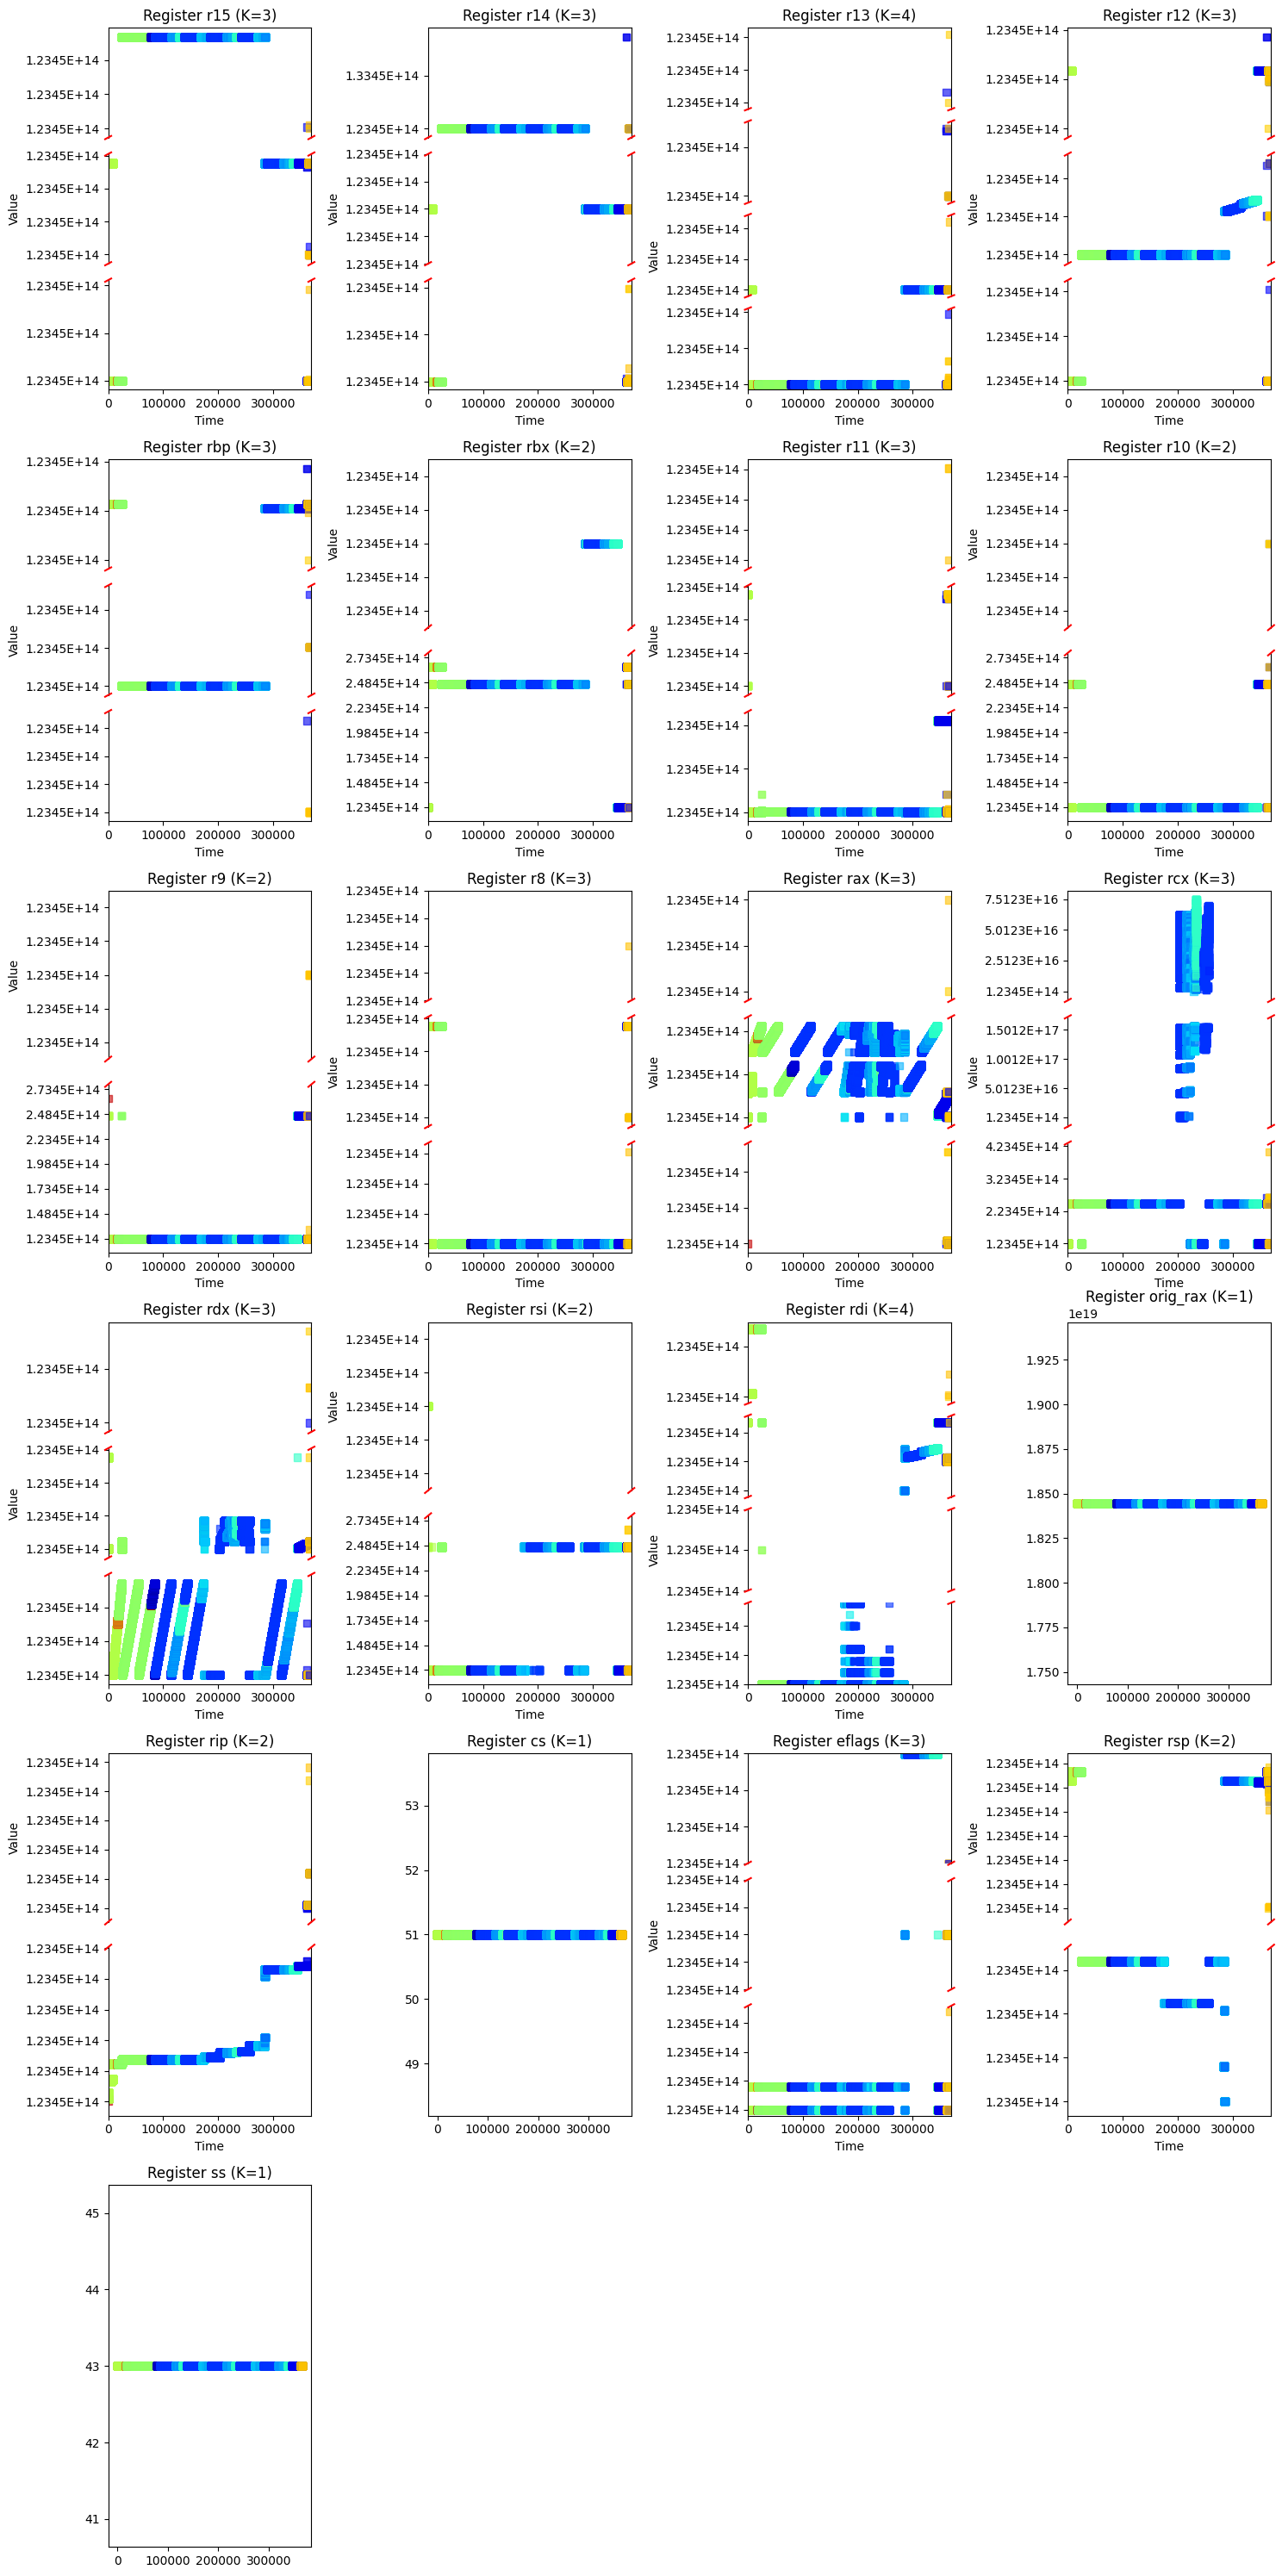

In [ ]:
fig,axg = plot_register_data(all_regs_data,custom_Ks=[3,3,4,3,3,2,3,2,2,3,3,3,3,2,4,1,2,1,3,2,1],alpha=5e14)
fig.savefig("outs/reg_clustered.png")